In [1]:
from fvhoe.boundary_conditions import BoundaryCondition
from fvhoe.initial_conditions import shock_tube_1d
from fvhoe.solver import EulerSolver
import matplotlib.pyplot as plt
import numpy as np
import sys
import warnings

warnings.filterwarnings("ignore")

sd_path = "/home/jp7427/Desktop/sd/"

sys.path.append(sd_path + "src")
sys.path.append(sd_path + "utils")
sys.path.append(sd_path + "ODE")

from sd_simulator import SD_Simulator
from initial_conditions_2d import sod_shock_tube

CuPy not available, falling back to NumPy


In [2]:
def sd_plot_1d(ax, sd, param, **kwargs):
    # s.dm.W_cv has shape (nvar,Ny,Nx,n+1,n+1)
    # the function transpose_to_fv reshapes it to (nvar,Ny(n+1),Nx(n+1))
    # which is compatible with visualization
    W = sd.transpose_to_fv(sd.dm.W_cv)
    tr = sd.dm.trouble
    x = sd.dm.x_cv[2:-2]
    var = {"rho": 0, "vx": 1, "P": 3}[param]
    ax.plot(x, W[var][0], **kwargs)

In [3]:
N = 40
p = 3
T = 0.245
gamma = 1.4

In [4]:
# initialize solvers
fv_solver = EulerSolver(
    w0=shock_tube_1d,
    nx=N * (p + 1),
    px=p,
    riemann_solver="hllc",
    bc=BoundaryCondition(
        x="dirichlet",
        x_value=(
            {"rho": 1, "E": 1 / (gamma - 1), "mx": 0, "my": 0, "mz": 0},
            {"rho": 0.125, "E": 0.1 / (gamma - 1), "mx": 0, "my": 0, "mz": 0},
        ),
    ),
    gamma=gamma,
    a_posteriori_slope_limiting=True,
)

sd_solver = SD_Simulator(
    n=p,
    Nx=N,
    Ny=1,
    init_fct=sod_shock_tube,
    BC=["ic", "periodic"],
    gamma=gamma,
    detect_troubles=True,
    limiting_vars=[0, 1, 3],
    use_cupy=False,
)

In [5]:
# solve with finite volumes

fv_solver.rkorder(T, save_snapshots=False)

100%|██████████| 0.245/0.245 [00:11]                


In [6]:
# solve with spectral differences
sd_solver.perform_time_evolution(T)

337 time steps (t = 0.245, Execution time: 5.200818 s)12499960396539528, min p = 0.09999992535065783)


t=0.00, x=[0.00, 1.00], y=0.50, z=0.50
t=0.24, x=[0.00, 1.00], y=0.50, z=0.50
t=0.00, x=[0.00, 1.00], y=0.50, z=0.50
t=0.24, x=[0.00, 1.00], y=0.50, z=0.50
t=0.00, x=[0.00, 1.00], y=0.50, z=0.50
t=0.24, x=[0.00, 1.00], y=0.50, z=0.50


Text(0.5, 0, '$x$')

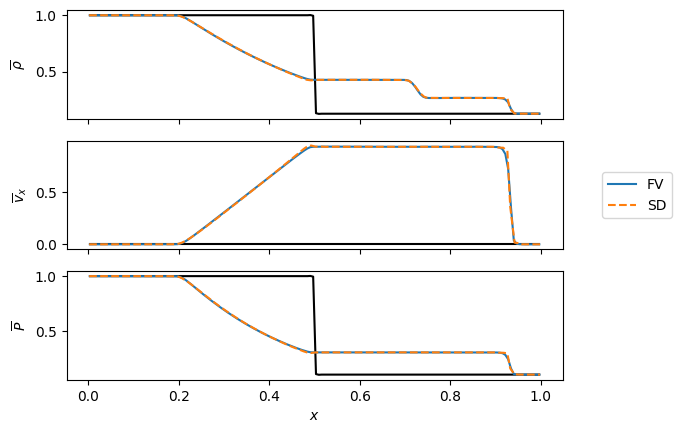

In [7]:
fig, ax = plt.subplots(3, sharex=True)

for i, (var, label) in enumerate(
    zip(
        ["rho", "vx", "P"],
        [r"$\overline{\rho}$", r"$\overline{v}_x$", r"$\overline{P}$"],
    )
):
    fv_solver.plot_1d_slice(ax[i], t=0, color="k", param=var, y=0.5, z=0.5)
    fv_solver.plot_1d_slice(ax[i], t=T, param=var, y=0.5, z=0.5, label="FV")
    sd_plot_1d(ax[i], sd_solver, param=var, linestyle="--", label="SD")
    ax[i].set_ylabel(label)

ax[1].legend(loc="center", bbox_to_anchor=(1.15, 0.5))
ax[2].set_xlabel("$x$")